In [7]:

# Imporing required Packages/Modules
import os
import tensorflow as tf
import datetime
import numpy as np # For array-related manipulations
import pandas as pd # For DataFrame-related operations 
import matplotlib.pyplot as plt # Useful for graph plotting
import seaborn as sns # Another easy graph module
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Will be used for model evaluation
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, load_model # Base class for most Neural Networks
from keras.optimizers import Adam # Model Optimizer for Model fitting
from keras.utils import to_categorical # For converting label to categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.svm import SVC
from keras.layers import Input, Conv2D, MaxPool2D, Dense
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers, losses, models, layers 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import Concatenate, Flatten, Dense, Dropout  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import time



In [8]:

# Define parameters
CLASS_NUM = 11
BATCH_SIZE = 16
EPOCH_STEPS = int(4323 / BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 3)
IMAGE_TRAIN = r'Sugarcane Leaf Image Dataset Split'
MODEL_NAME = 'googlenet_Sugarcane.h5'

# Prepare data for training
Data_Generator = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

def my_generator(generator):
    while True:  # Keras requires all generators to be infinite
        data = next(generator)
        x = data[0]
        y = data[1], data[1], data[1]
        yield x, y


train_set = Data_Generator.flow_from_directory(
    directory=IMAGE_TRAIN + r'/train',
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='training'
)

train_generator = my_generator(train_set)

# Prepare data for validation
val_generator = Data_Generator.flow_from_directory(
    directory=IMAGE_TRAIN + r'/test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

test_generator = my_generator(val_generator)

# # Prepare data for testing
# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_directory(
#     directory=IMAGE_TRAIN + '/test',
#     target_size=(224, 224),
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )

# Now, you can use these generators in model.fit for training and validation, and for evaluating the model on the test set.


Found 3884 images belonging to 11 classes.
Found 267 images belonging to 11 classes.


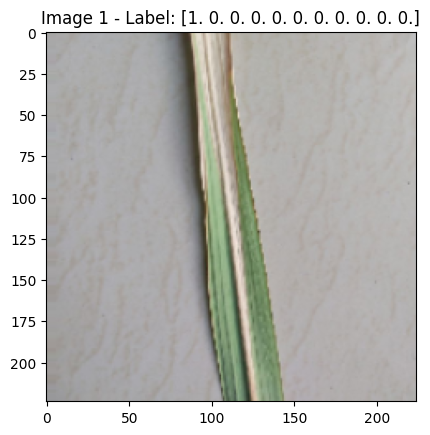

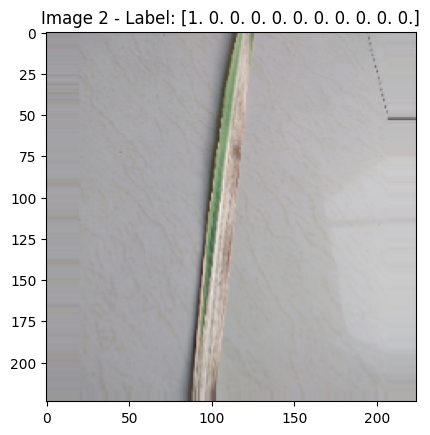

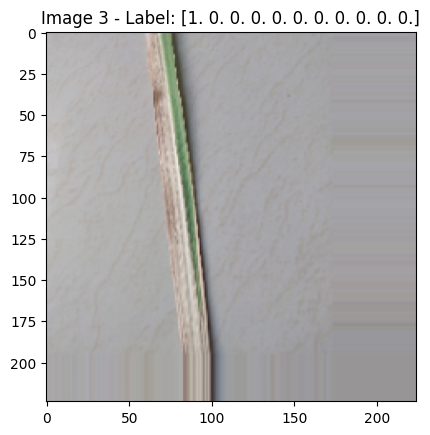

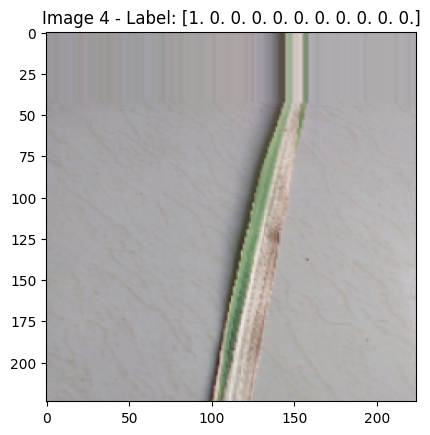

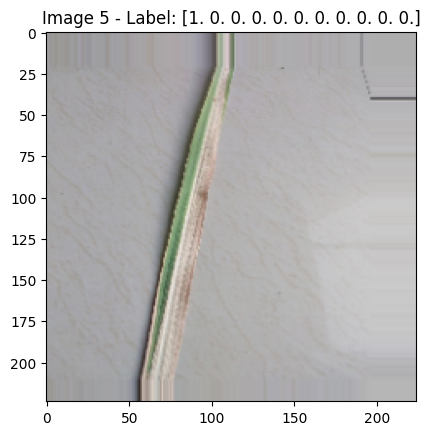

In [9]:
import matplotlib.pyplot as plt

# Extract the images and labels from the batch
images, labels = next(train_set)

# Output the first five images
for i in range(5):
    # Display the current image and label using matplotlib
    plt.imshow(images[i])
    plt.title(f"Image {i + 1} - Label: {labels[i]}")
    plt.show()


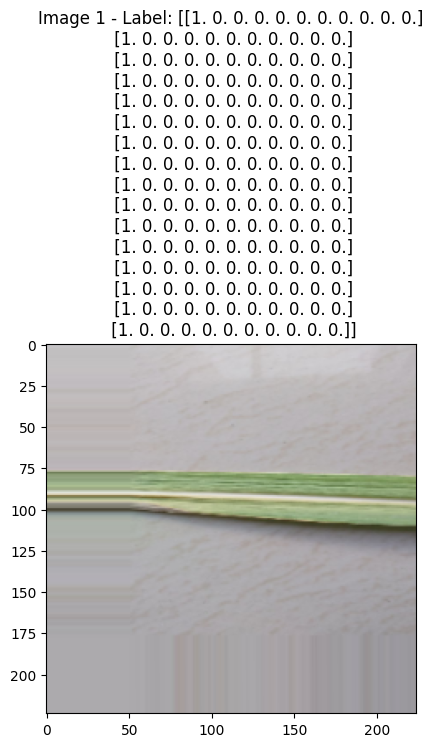

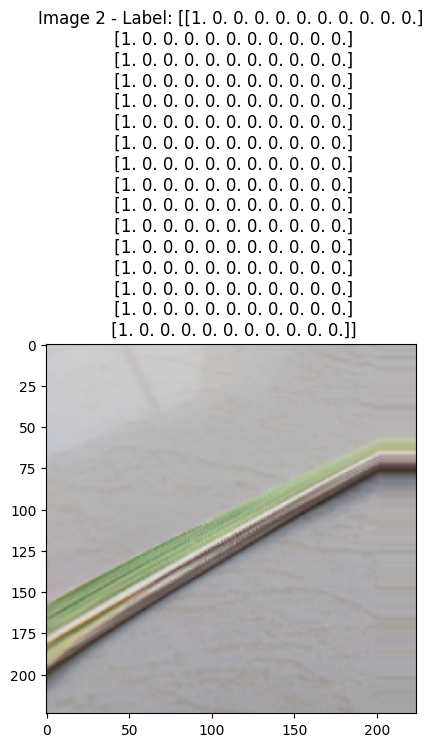

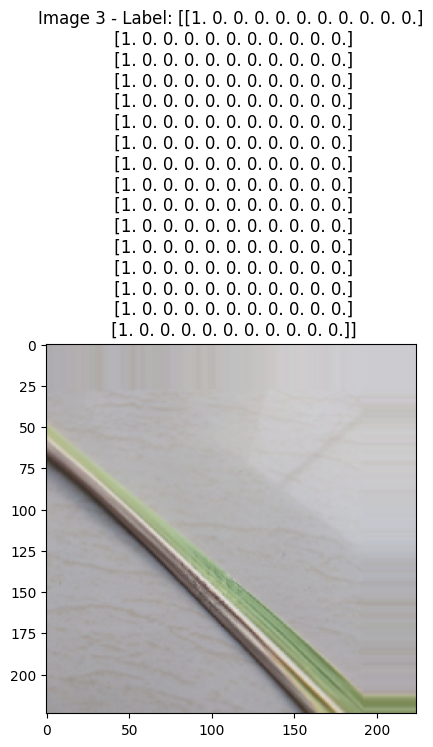

In [10]:
import matplotlib.pyplot as plt

# Extract the images and labels from the batch
images, labels = next(test_generator)

# Output the first five images
for i in range(3):
    # Display the current image and label using matplotlib
    plt.imshow(images[i])
    plt.title(f"Image {i + 1} - Label: {labels[i]}")
    plt.show()


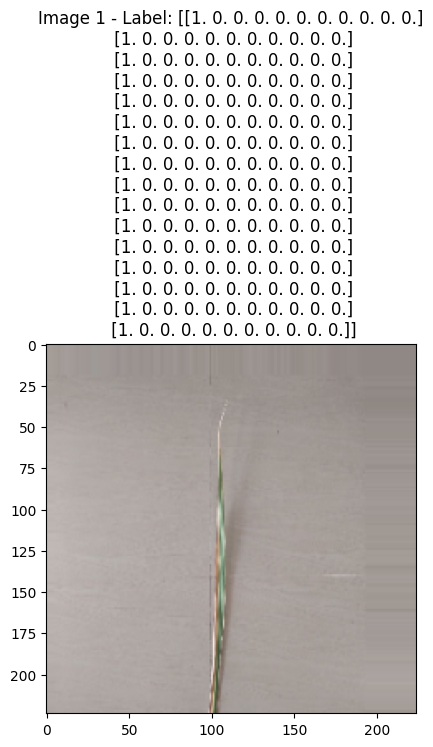

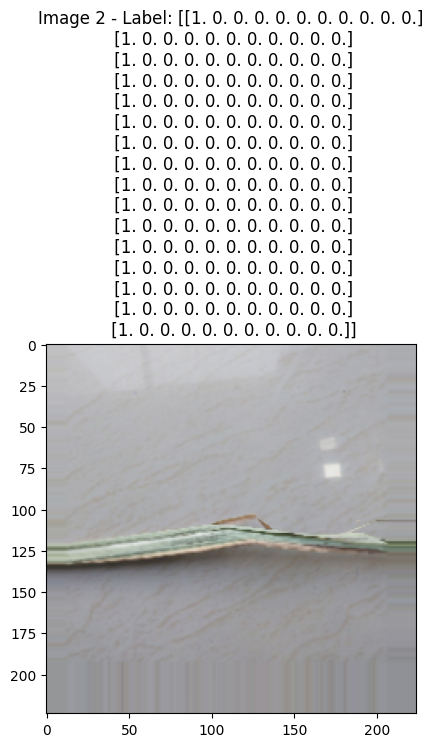

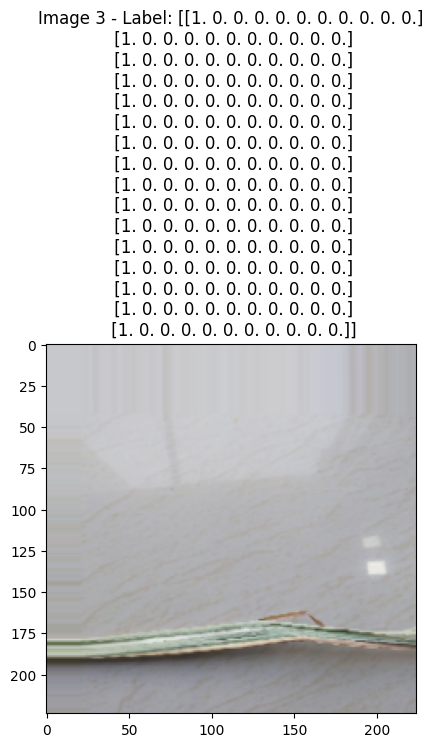

In [11]:
import matplotlib.pyplot as plt

# Extract the images and labels from the batch
images, labels = next(train_generator)

# Output the first five images
for i in range(3):
    # Display the current image and label using matplotlib
    plt.imshow(images[i])
    plt.title(f"Image {i + 1} - Label: {labels[i]}")
    plt.show()


In [12]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)
  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)
  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
  return tf.concat([path1, path2, path3, path4], axis=3)
inp = layers.Input(shape=(32, 32, 3))

input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(IMAGE_SHAPE))(inp)
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)
x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2) 
aux2 = layers.Dense(10, activation='softmax')(aux2)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(inputs = inp, outputs = [out, aux1, aux2])


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']             

In [ ]:
# optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
# epochs = [20, 30, 20, 30]
# history_all = {}

# for i in range(len(optimizer)):
#     print('Usnig optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
#     model.compile(loss='categorical_crossentropy', 
#                   loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
#                   optimizer=optimizer[i], metrics=['accuracy'])
    
#     train_history = model.fit_generator(
#             train_generator,
#             steps_per_epoch=EPOCH_STEPS,
#             epochs=epochs[i],
#             #callbacks=[checkpoint]
#             shuffle=True
#             )
    
#     # save history    
#     if len(history_all) == 0:
#         history_all = {key: [] for key in train_history.history}
    
#     for key in history_all:
#         history_all[key].extend(train_history.history[key])

# model.save(MODEL_NAME)

# # show train history
# def show_train_history(history, xlabel, ylabel, train):
#     for item in train:
#         plt.plot(history[item])
#     plt.title('Train History')
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.legend(train, loc='upper left')
#     plt.show()

# show_train_history(history_all, 'Epoch', 'Accuracy', ('main_acc', 'aux1_acc', 'aux2_acc'))
# show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))



In [15]:
# CALLBACKS
%load_ext tensorboard
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='min',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = EarlyStopping(monitor='val_loss',
                                       patience=3,
                                       verbose=1,
                                       mode='min')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = ModelCheckpoint(f'GoogleNet-modelv1-{datetime.datetime.now().__format__("%Y-%m-%d-%H-%M-%S")}.h5',
                                         monitor='val_loss',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='min',
                                         save_freq='epoch')

#Tensorboard
current_time = datetime.datetime.now().__format__('%Y-%m-%d-%H-%M-%S')
tb_callback = TensorBoard(log_dir=f"./logs/GoogleNetv1-modelv1-{current_time}", histogram_freq=2)

In [16]:


# Record the start time
start_time = time.time()

model.compile(optimizer='adam', 
              loss=[losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy],
              loss_weights=[1, 0.3, 0.3],
              metrics=['accuracy'])

# Training
train_history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    validation_data=val_generator,
    steps_per_epoch=EPOCH_STEPS,
    epochs=30,
    verbose=1,
    shuffle=True,
    callbacks=[lr_reduce, checkpoint, tb_callback]
)

# Record the end time
end_time = time.time()

# Calculate and print the total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Jerico\AppData\Local\Temp\ipykernel_32544\3020620144.py", line 12, in <module>
      train_history = model.fit(
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [16,10] and labels shape [176]
	 [[{{node sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_7509]

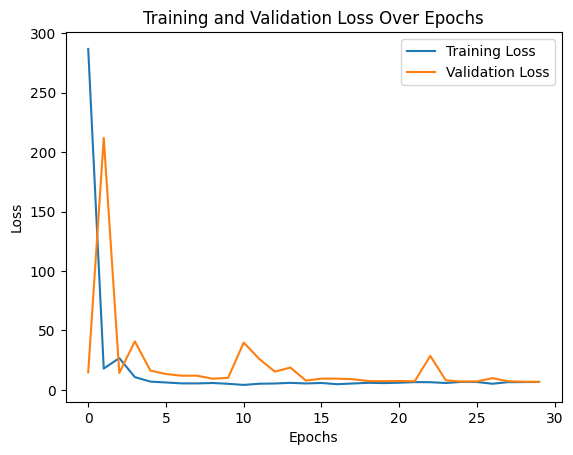

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in the variable 'train_history'

# Plot the training loss
plt.plot(train_history.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(train_history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


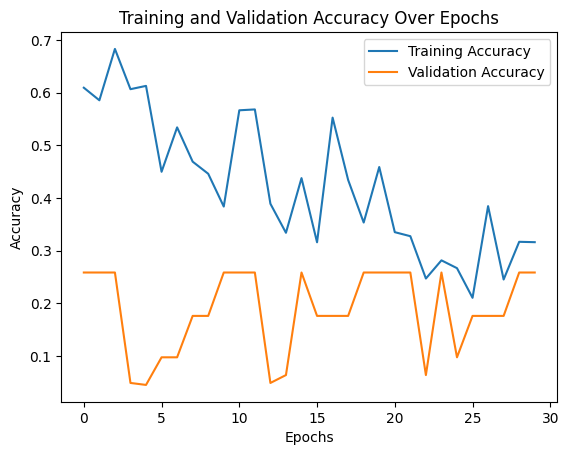

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in the variable 'train_history'

# Plot the training accuracy
plt.plot(train_history.history['main_accuracy'], label='Training Accuracy')

# Plot the validation accuracy
plt.plot(train_history.history['val_main_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the true labels and predicted labels for the test set
true_labels = train_generator.classes

# Ensure that model.predict returns a NumPy array
predicted_probs = model.predict(train_generator)
if isinstance(predicted_probs, list):
    # Concatenate the predictions from multiple branches (assuming main branch is the first)
    predicted_probs = np.concatenate(predicted_probs, axis=1)

# Convert predicted probabilities to class indices
predicted_labels = predicted_probs.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


AttributeError: 'generator' object has no attribute 'classes'

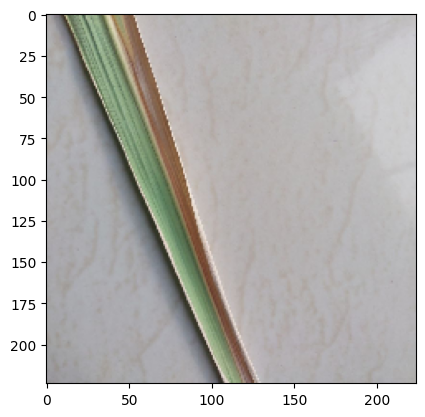

In [ ]:
import matplotlib.pyplot as plt

# Display the first image in the batch
plt.imshow(images[0])
plt.show()


# Constraints

In [ ]:
# Extract a batch of images from your dataset
images, _ = next(test_set)

# Measure inference time for making predictions
start_time = time.time()

# Assuming your model is named 'model' and you want predictions for the batch of images
predictions = model.predict(images)

end_time = time.time()

# Calculate and print the inference time
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

1/1 [==============================] - 0s 394ms/step
Inference Time: 0.4328 seconds


In [ ]:
def get_model_size(model):
    # Save the model to a temporary file
    model.save('temp_model.h5')

    # Get the size of the saved model file
    model_size = os.path.getsize('temp_model.h5')

    # Remove the temporary file
    os.remove('temp_model.h5')

    return model_size

# Load your model
model = tf.keras.models.load_model(r'D:\New_Fourth_Year\projectDesignGit\GoogleNet-modelv1-2023-12-05-22-40-13.h5')

# Get the size of the model
model_size_bytes = get_model_size(model)

# Convert bytes to megabytes for better readability
model_size_megabytes = model_size_bytes / (1024 * 1024)

print(f"Model Size: {model_size_megabytes:.2f} MB")


Model Size: 85.57 MB


In [ ]:
model = tf.keras.models.load_model(r'D:\New_Fourth_Year\projectDesignGit\GoogleNet-modelv1-2023-12-05-22-40-13.h5')
# Assuming you have a test set generator
test_set = test_set  # Define or load your test set generator

# Use model.evaluate to get accuracy and other metrics
results = model.evaluate(test_set, verbose=1)  # Set verbose=1 for more information

# 'results' is a list containing the evaluation metrics
accuracy = results[1]  # Index 1 corresponds to the accuracy

# Compute misclassification rate
misclassification_rate = 1 - accuracy

print(f'Misclassification Rate: {misclassification_rate * 100:.2f}%')



170/170 [==============================] - 6s 30ms/step - loss: 6.8448 - main_loss: 2.2245 - aux1_loss: 2.3170 - aux2_loss: 2.3034 - main_accuracy: 0.2546 - aux1_accuracy: 0.2546 - aux2_accuracy: 0.2546
Misclassification Rate: -122.45%


In [ ]:
# 'results' is a list containing the evaluation metrics
main_accuracy = results[4]  # Index 4 corresponds to the accuracy of the main branch

print(f'Main Branch Accuracy: {main_accuracy:.2%}')


Main Branch Accuracy: 25.46%


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have the true labels and predicted labels for the test set
true_labels = test_set.classes

# Ensure that model.predict returns a NumPy array
predicted_probs = model.predict(test_set)
if isinstance(predicted_probs, list):
    # Concatenate the predictions from multiple branches (assuming main branch is the first)
    predicted_probs = np.concatenate(predicted_probs, axis=1)

# Convert predicted probabilities to class labels
predicted_labels = predicted_probs.argmax(axis=1)

# Compute accuracy using sklearn's accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute misclassification rate
misclassification_rate = 1 - accuracy

print(f'Misclassification Rate: {misclassification_rate:.2%}')


170/170 [==============================] - 6s 33ms/step
Misclassification Rate: 96.31%


In [ ]:
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            return flops.total_float_ops

In [ ]:
model_h5_path = r'D:\New_Fourth_Year\projectDesignGit\GoogleNet-modelv1-2023-12-05-22-40-13.h5'
# Get and print the FLOPs
flops = get_flops(model_h5_path)
print(f"Number of FLOPs: {flops}")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Number of FLOPs: 7419667
